In [1]:
import qiskit 
from qiskit import *
from qiskit.visualization import plot_histogram as hist
from math import pi

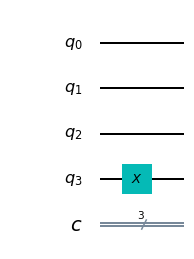

In [2]:
qc=QuantumCircuit(4,3)
qc.x(3)
qc.draw("mpl")

In [3]:
def phase_circuit(qc,theta):
    for qubit in range(qc.num_qubits-1):
        qc.h(qubit)
    repetitions=1
    angle=2*pi*theta
    for qubit in range(qc.num_qubits-1):
        for i in range(repetitions):
            qc.cu1(angle, qubit, qc.num_qubits-1)
        repetitions *= 2
    qc.barrier()
    
    n=qc.num_qubits-1
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cu1(-pi/float(2**(j-m)), m, j)
        qc.h(j)
    
    qc.barrier()
    for n in range(qc.num_qubits-1):
        qc.measure(n,n)
    
    return qc

In [4]:
#For the T gate we know theta=1/8
qc=phase_circuit(qc,1/8)

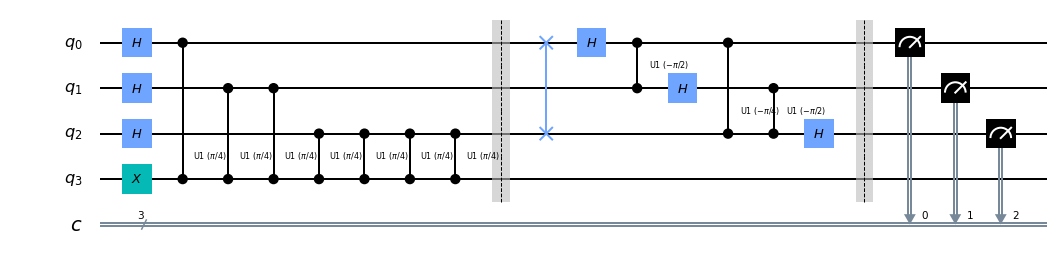

In [5]:
qc.draw("mpl")

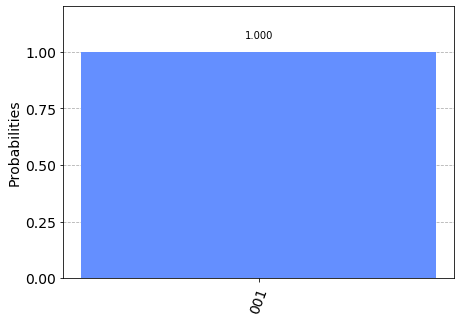

In [6]:
result=execute(qc,backend=Aer.get_backend(name="qasm_simulator"),shots=2048).result()
counts=result.get_counts()
hist(counts)

#### We see we get one result (001) with certainty, which translates to the decimal: 1. We now need to divide our result (1) by  2^n  to get  θ = 1/8

In [7]:
IBMQ.load_account()
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 4 and not x.configuration().simulator and x.status().operational==True))
print("Least busy backend: ", backend)

Least busy backend:  ibmqx2


In [8]:
job=execute(qc,backend=provider.get_backend("ibmq_16_melbourne"),shots=2048)
job_monitor(job)

Job Status: job has successfully run


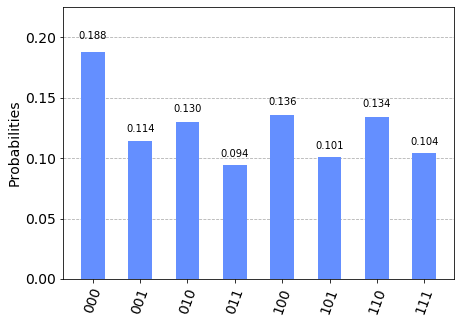

In [9]:
result=job.result()
counts=result.get_counts()
hist(counts)

In [10]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)
qr = qiskit.QuantumRegister(3)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

In [11]:
job = qiskit.execute(meas_calibs, backend=provider.get_backend("ibmq_16_melbourne"), shots=2048,)
cal_results = job.result()

In [12]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
meas_filter = meas_fitter.filter
# Results with mitigation
mitigated_results = meas_filter.apply(result)
mitigated_counts = mitigated_results.get_counts()

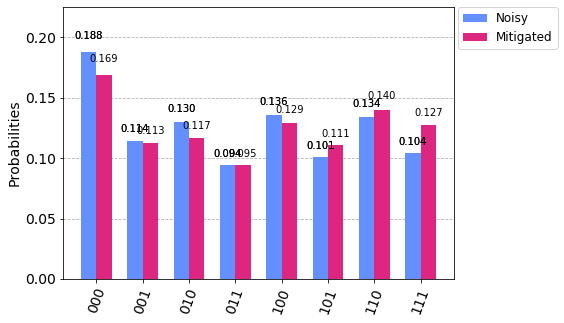

In [13]:
hist([counts, mitigated_counts], legend=['Noisy', 'Mitigated'])

## To get more precision we simply add more counting qubits. Lets try with theta  θ = 1/3

In [14]:
qc=QuantumCircuit(6,5)
qc.x(5)

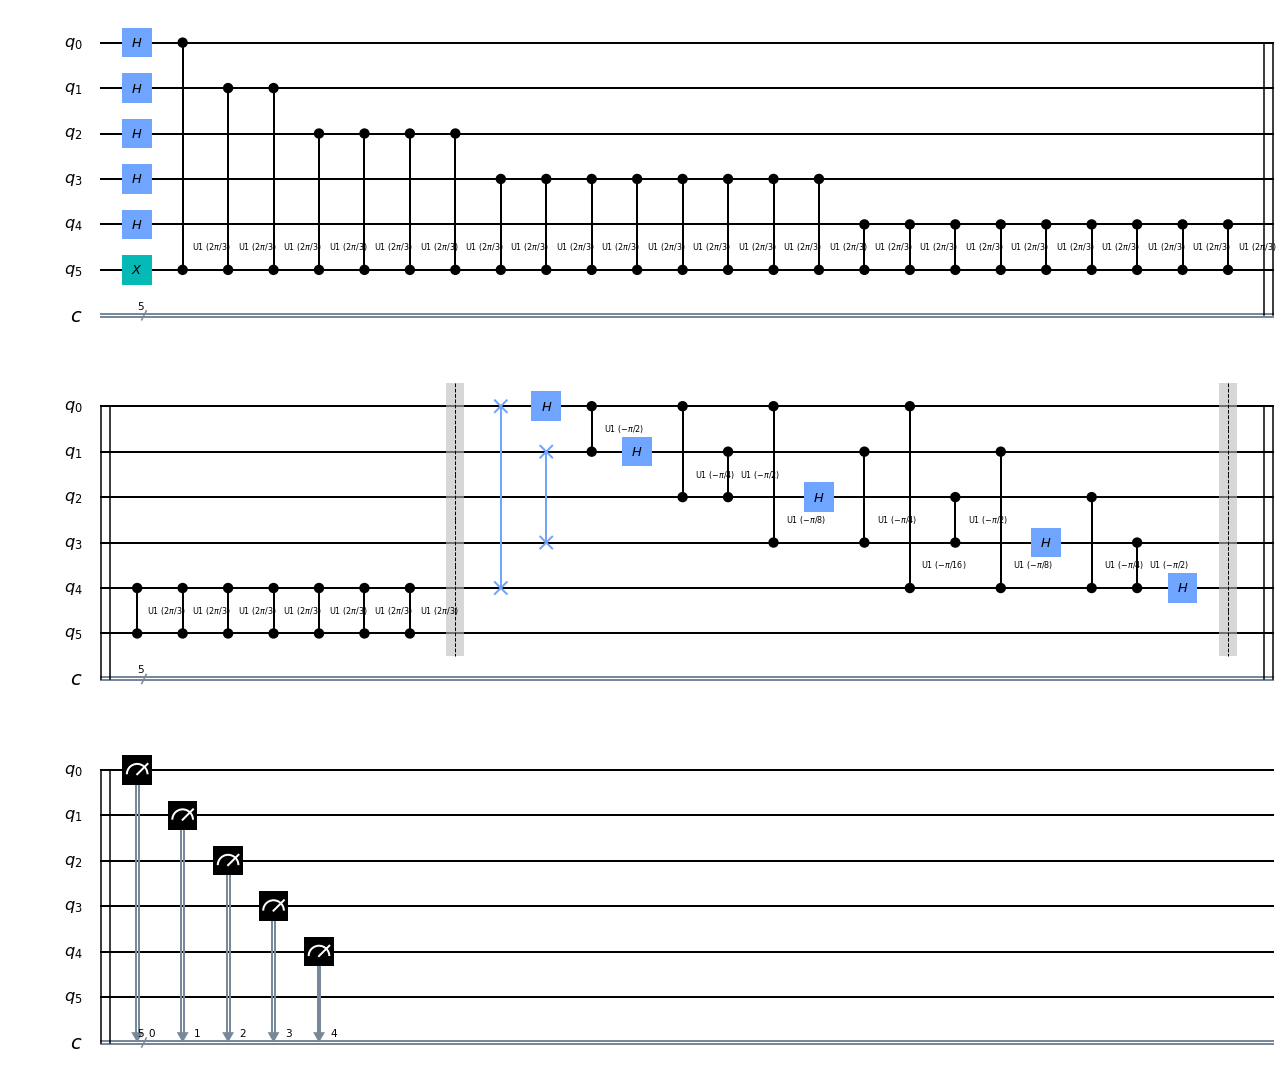

In [15]:
qc=phase_circuit(qc,1/3)
qc.draw("mpl")

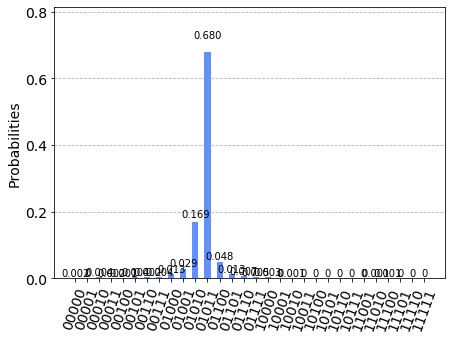

In [16]:
result=execute(qc,backend=Aer.get_backend(name="qasm_simulator"),shots=2048).result()
counts=result.get_counts()
hist(counts)

### The two most likely measurements are now 01011 (decimal 11) and 01010 (decimal 10). These results would tell us that  0.313 < θ < 0.344  